In [1]:
# TODO
# p-value / statistic
# finalize plot


import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from data_loading import (load_y2h_isoform_data, 
    load_m1h_activation_data, 
    load_ppi_partner_categories, 
    load_valid_isoform_clones,
    load_human_tf_db,
    load_y1h_pdi_data)
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data()
cats = load_ppi_partner_categories()

In [27]:
cof = pd.read_csv('../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                 sep='\t')
if cof['Symbol'].duplicated().any():
    raise UserWarning('unexpected duplicates')

In [34]:
cof.tail()

,Species,Symbol,Ensembl,Family,Entrez ID
1020,Homo_sapiens,TAF9,ENSG00000273841,TATA-box,6880
1021,Homo_sapiens,MLLT6,ENSG00000275023,Others,4302
1022,Homo_sapiens,AATF,ENSG00000275700,Others,26574
1023,Homo_sapiens,PCGF2,ENSG00000277258,PCGF,7703
1024,Homo_sapiens,PAGR1,ENSG00000280789,Others,79447


In [35]:
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [36]:
# number of cofactors
# number of PPI with cofactors
# split by family
print(cof.shape[0], 'cofactors')
print(y2h.loc[y2h['db_gene_symbol'].isin(cof['Symbol']), 'db_gene_symbol'].nunique(),
      ' of which we have PPIs for')
print(y2h['db_gene_symbol'].isin(cof['Symbol']).sum(),
      ' cofactor PPIs')
cof_with_ppi = set(y2h.loc[y2h['db_gene_symbol'].isin(cof['Symbol']), 'db_gene_symbol'].unique())
print(cof.loc[cof['Symbol'].isin(cof_with_ppi), 'Family'].value_counts())

1025 cofactors
63  of which we have PPIs for
465  cofactor PPIs
Others                      29
Other_CRF                    4
LIM                          3
Cyclin                       2
Vestigial like               2
Ring finger protein          2
Histone deacetylase          2
WD                           1
HNRNP                        1
MAGE                         1
TEF                          1
INO80 complex                1
TATA-box                     1
Tripartite motif             1
Mediator complex             1
SSX                          1
NFKB associated              1
PHF                          1
DPF                          1
SMYD                         1
WW                           1
FHL                          1
Chromobox                    1
RNA helicase                 1
Bromodomain                  1
Lysine acetyltransferase     1
Name: Family, dtype: int64


In [81]:
df = pd.read_excel('../data/external/Geiger-et-al_MCP_2012_Supplementary-Table-2.xlsx',
                   skiprows=1)
hek_avrg = df[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
print((hek_avrg > 0).sum(), 'proteins expressed in HEK293 proteome')
hek_expressed_genes = set(df.loc[(hek_avrg > 0) & df['Gene Names'].notnull(),
       'Gene Names'].str.split(';').explode().values)
all_partners = set(y2h['db_gene_symbol'].unique())
print('of {} PPI partners, {} are expressed in HEK293 cells'.format(len(all_partners), 
      len(all_partners.intersection(hek_expressed_genes))))


8543 proteins expressed in HEK293 proteome
of 511 PPI partners, 252 are expressed in HEK293 cells


In [77]:
pairs = pairs_of_isoforms_comparison_table(isoforms=load_valid_isoform_clones(),
                                           y2h=y2h,
                                           m1h=m1h,
                                           y1h=load_y1h_pdi_data())


def add_restricted_ppi_columns(pairs, rows, label):
    pairs_cf = pairs_of_isoforms_comparison_table(isoforms=load_valid_isoform_clones(),
                                                  y2h=y2h.loc[rows, :])
    return pd.merge(pairs, 
                    pairs_cf.loc[:, [c for c in pairs_cf.columns if c.startswith('ppi')]], 
                    how='left', left_index=True, right_index=True,
                    suffixes=('', '_' + label))


cofactor_partners = set(cats.loc[cats['category'] == 'cofactor', 'partner'].unique())
coactivator_partners = set(cats.loc[cats['cofactor_type'] == 'coactivator', 'partner'].unique())
corepressor_partners = set(cats.loc[cats['cofactor_type'] == 'corepressor', 'partner'].unique())
cofactor_animal_db = set(cof['Symbol'].unique())
tf_gene_symbols = set(load_human_tf_db()['HGNC symbol'].values)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_animal_db),
                           label='cofactors_animal_db'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 ~y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_not_HEK'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=~y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='not_cofactors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(coactivator_partners),
                           label='coactivators'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(corepressor_partners),
                           label='corepressors'
)
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(tf_gene_symbols),
                           label='tfs'
)

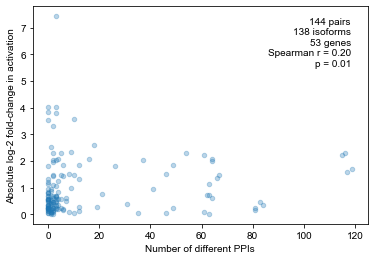

In [5]:
def scatter_with_correlation(x, y, pairs=pairs, x_label=None, y_label=None):
    """
    TODO:
        - calculate p-value properly
            - this requires permuting in some smart way
            - one question is whether the genes are the number of independent data points or the isoforms are
            - I think the answer is the isoforms are
    
    """
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    fig, ax = plt.subplots(1, 1)
    pairs.plot.scatter(x=x, y=y, ax=ax, alpha=0.3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (pairs[x].notnull() & pairs[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(pairs.loc[with_data, ['clone_acc_a', 'clone_acc_b']].values.flatten()))
    n_gene = pairs.loc[with_data, 'tf_gene_symbol'].nunique()
    scc, p_scc = stats.spearmanr(pairs.loc[pairs[x].notnull() & pairs[y].notnull(), x].values,
                    pairs.loc[pairs[x].notnull() & pairs[y].notnull(), y].values)
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\nSpearman r = {scc:.2f}\np = {p_scc:.2f}',
            x=0.95,
            y=0.95,
            ha='right',
            va='top',
            transform=ax.transAxes)
    fig.savefig(f'../figures/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

scatter_with_correlation(
    x='ppi_n_diff',
    y='activation_abs_fold_change',
    x_label='Number of different PPIs',
    y_label='Absolute log-2 fold-change in activation')

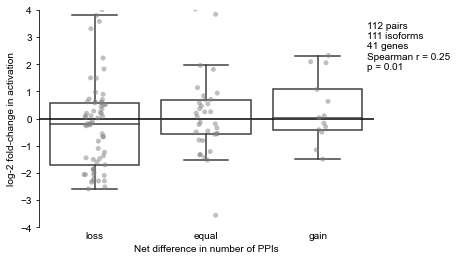

In [15]:
def bar_activation_vs_ppi(x, y, pairs=pairs, x_label=None, y_label=None):
    """
    TODO:
        - calculate p-value properly
            - this requires permuting in some smart way
            - one question is whether the genes are the number of independent data points or the isoforms are
            - I think the answer is the isoforms are
    
    """
    df = pairs.copy()
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    fig, ax = plt.subplots(1, 1)

    def bin_delta_ppi(delta_ppi):
        if pd.isnull(delta_ppi):
            return np.nan
        if delta_ppi < 0:
            return 'loss'
        elif delta_ppi > 0:
            return 'gain'
        elif delta_ppi == 0:
            return 'equal'
        else:
            raise ValueError(delta_ppi)


    df[x + '_binned'] = df[x].apply(bin_delta_ppi)
    sns.stripplot(data=df,
                  x=x + '_binned',
                  y=y,
                  order=['loss', 'equal', 'gain'],
                  alpha=0.5,
                  color='grey',
                  ax=ax)
    if False:
        sns.pointplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    alpha=0.5,
                    color='black',
                    ax=ax)
    if True:
        sns.boxplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    boxprops={'facecolor': 'w'}, 
                    fliersize=0,
                    ax=ax)
    else:
        sns.violinplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['loss', 'equal', 'gain'],
                    color='lightgrey',
                    ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (df[x].notnull() & df[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(df.loc[with_data, ['clone_acc_a', 'clone_acc_b']].values.flatten()))
    n_gene = df.loc[with_data, 'tf_gene_symbol'].nunique()
    scc, p_scc = stats.spearmanr(df.loc[df[x].notnull() & df[y].notnull(), x].values,
                    df.loc[df[x].notnull() & df[y].notnull(), y].values)
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\nSpearman r = {scc:.2f}\np = {p_scc:.2f}',
            x=0.98,
            y=0.95,
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.set_ylim(-4, 4) # NOTE cuts outlier TODO add broken axis
    ax.axhline(y=0, color='black')
    for pos in ['top', 'bottom', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../figures/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

bar_activation_vs_ppi(
    pairs=pairs.loc[(pairs['m1h_min'] < -1) | (pairs['m1h_max'] > 1), :],
    x='ppi_delta_n',
    y='activation_fold_change',
    x_label='Net difference in number of PPIs',
    y_label='log-2 fold-change in activation')

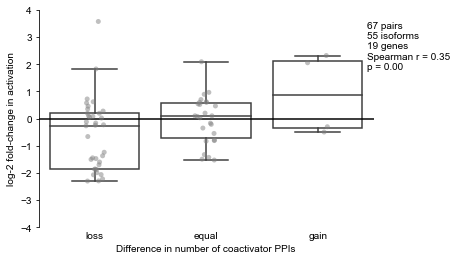

In [16]:
bar_activation_vs_ppi(
    pairs=pairs.loc[(pairs['m1h_min'] < -1) | (pairs['m1h_max'] > 1), :],
    x='ppi_delta_n_coactivators',
    y='activation_fold_change',
    x_label='Difference in number of coactivator PPIs',
    y_label='log-2 fold-change in activation')

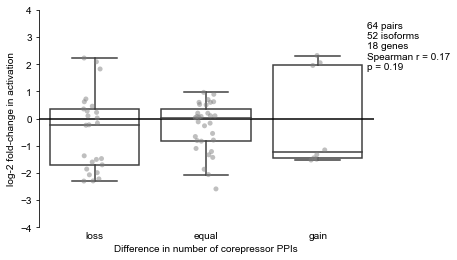

In [26]:
bar_activation_vs_ppi(
    pairs=pairs.loc[(pairs['m1h_min'] < -1) | (pairs['m1h_max'] > 1), :],
    x='ppi_delta_n_corepressors',
    y='activation_fold_change',
    x_label='Difference in number of corepressor PPIs',
    y_label='log-2 fold-change in activation')

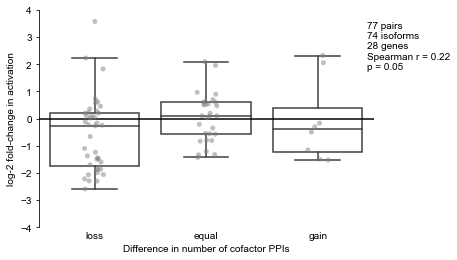

In [24]:
bar_activation_vs_ppi(
    pairs=pairs.loc[(pairs['m1h_min'] < -1) | (pairs['m1h_max'] > 1), :],
    x='ppi_delta_n_cofactors_animal_db',
    y='activation_fold_change',
    x_label='Difference in number of cofactor PPIs',
    y_label='log-2 fold-change in activation')

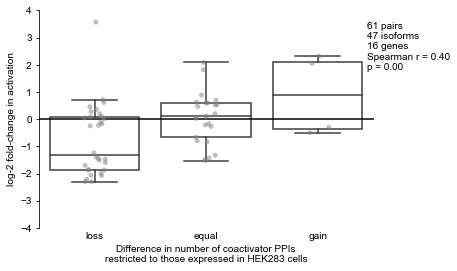

In [78]:
bar_activation_vs_ppi(
    pairs=pairs.loc[(pairs['m1h_min'] < -1) | (pairs['m1h_max'] > 1), :],
    x='ppi_delta_n_coactivators_HEK',
    y='activation_fold_change',
    x_label='Difference in number of coactivator PPIs\nrestricted to those expressed in HEK283 cells',
    y_label='log-2 fold-change in activation')

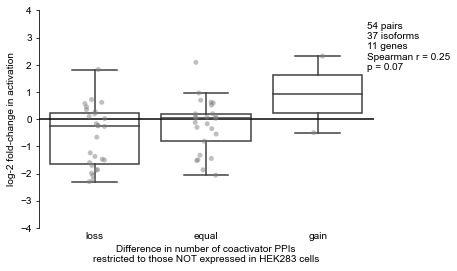

In [80]:
# this is not correct
# what I want is the pairs where all the lost cofactors are not expressed
bar_activation_vs_ppi(
    pairs=pairs.loc[(pairs['m1h_min'] < -1) | (pairs['m1h_max'] > 1), :],
    x='ppi_delta_n_coactivators_not_HEK',
    y='activation_fold_change',
    x_label='Difference in number of coactivator PPIs\nrestricted to those NOT expressed in HEK283 cells',
    y_label='log-2 fold-change in activation')

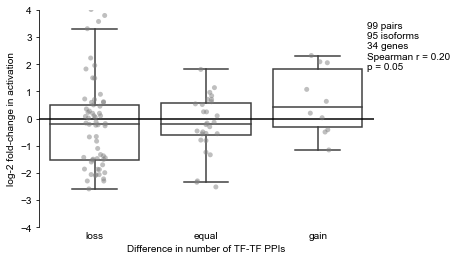

In [40]:
bar_activation_vs_ppi(
    pairs=pairs.loc[(pairs['m1h_min'] < -1) | (pairs['m1h_max'] > 1), :],
    x='ppi_delta_n_tfs',
    y='activation_fold_change',
    x_label='Difference in number of TF-TF PPIs',
    y_label='log-2 fold-change in activation')

8543 proteins expressed in HEK293 proteome


of 511 PPI partners, 252 are expressed in HEK293 cells


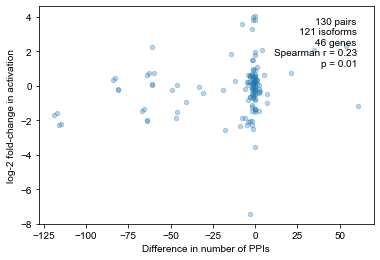

In [51]:
scatter_with_correlation(
    x='ppi_delta_n',
    y='activation_fold_change',
    x_label='Difference in number of PPIs',
    y_label='log-2 fold-change in activation')

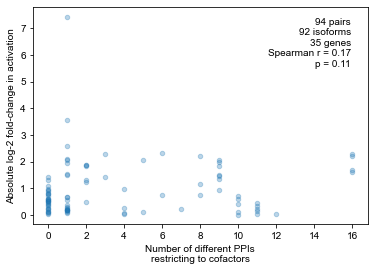

In [52]:
scatter_with_correlation(
    x='ppi_n_diff_cofactors',
    y='activation_abs_fold_change',
    x_label='Number of different PPIs\nrestricting to cofactors',
    y_label='Absolute log-2 fold-change in activation')

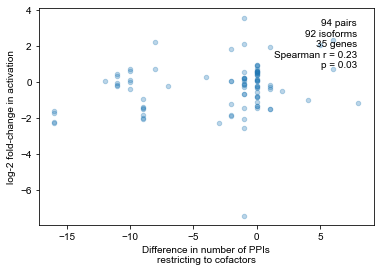

In [53]:
scatter_with_correlation(
    x='ppi_delta_n_cofactors',
    y='activation_fold_change',
    x_label='Difference in number of PPIs\nrestricting to cofactors',
    y_label='log-2 fold-change in activation')

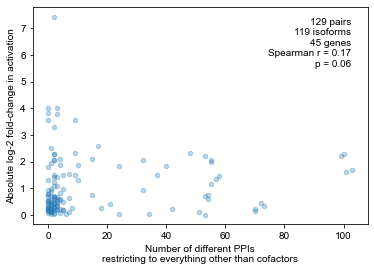

In [54]:
scatter_with_correlation(
    x='ppi_n_diff_not_cofactors',
    y='activation_abs_fold_change',
    x_label='Number of different PPIs\nrestricting to everything other than cofactors',
    y_label='Absolute log-2 fold-change in activation')

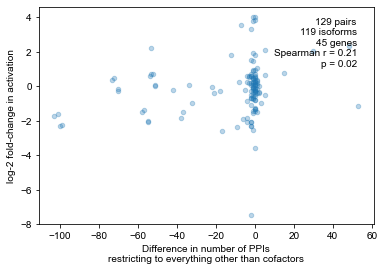

In [55]:
scatter_with_correlation(
    x='ppi_delta_n_not_cofactors',
    y='activation_fold_change',
    x_label='Difference in number of PPIs\nrestricting to everything other than cofactors',
    y_label='log-2 fold-change in activation')

In [22]:
pairs.loc[(pairs['ppi_n_tested_coactivators'] >= 1) & (pairs['ppi_n_diff_cofactors'] == 0), :]

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,ppi_n_tested_cofactors,ppi_n_shared_cofactors,ppi_n_min_cofactors,ppi_n_min_diff_cofactors,ppi_jaccard_cofactors,ppi_simpson_cofactors,ppi_n_diff_cofactors,ppi_delta_n_cofactors,ppi_n_tested_not_cofactors,ppi_n_shared_not_cofactors,ppi_n_min_not_cofactors,ppi_n_min_diff_not_cofactors,ppi_jaccard_not_cofactors,ppi_simpson_not_cofactors,ppi_n_diff_not_cofactors,ppi_delta_n_not_cofactors,ppi_n_tested_coactivators,ppi_n_shared_coactivators,ppi_n_min_coactivators,ppi_n_min_diff_coactivators,ppi_jaccard_coactivators,ppi_simpson_coactivators,ppi_n_diff_coactivators,ppi_delta_n_coactivators,ppi_n_tested_corepressors,ppi_n_shared_corepressors,ppi_n_min_corepressors,ppi_n_min_diff_corepressors,ppi_jaccard_corepressors,ppi_simpson_corepressors,ppi_n_diff_corepressors,ppi_delta_n_corepressors
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOXP2|1/10|07C01_FOXP2|2/10|07B01,FOXP2,FOXP2|1/10|07C01,FOXP2|2/10|07B01,16.0,12.0,12.0,0.0,0.750000,1.000000,4.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.597160,0.597160,96.5,6.0,6.0,6.0,0.0,1.0,1.0,0.0,0.0,10.0,6.0,6.0,0.0,0.600000,1.000000,4.0,-4.0,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0
FOXP2|1/10|07C01_FOXP2|4/10|12A06,FOXP2,FOXP2|1/10|07C01,FOXP2|4/10|12A06,15.0,11.0,11.0,0.0,0.733333,1.000000,4.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.830703,0.830703,84.1,6.0,6.0,6.0,0.0,1.0,1.0,0.0,0.0,9.0,5.0,5.0,0.0,0.555556,1.000000,4.0,-4.0,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0
FOXP2|2/10|07B01_FOXP2|4/10|12A06,FOXP2,FOXP2|2/10|07B01,FOXP2|4/10|12A06,12.0,10.0,11.0,1.0,0.833333,0.909091,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.427863,1.427863,87.1,6.0,6.0,6.0,0.0,1.0,1.0,0.0,0.0,6.0,4.0,5.0,1.0,0.666667,0.800000,2.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0
GLI1|1/3|10F09_GLI1|2/3|10E09,GLI1,GLI1|1/3|10F09,GLI1|2/3|10E09,5.0,5.0,5.0,0.0,1.000000,1.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,4.0,4.0,4.0,0.0,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLI1|1/3|10F09_GLI1|3/3|10E08,GLI1,GLI1|1/3|10F09,GLI1|3/3|10E08,4.0,4.0,4.0,0.0,1.000000,1.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GLI1|2/3|10E09_GLI1|3/3|10E08,GLI1,GLI1|2/3|10E09,GLI1|3/3|10E08,4.0,4.0,4.0,0.0,1.000000,1.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.5,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,0.0,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HNF4A|1/6|10D08_HNF4A|3/6|10C08,HNF4A,HNF4A|1/6|10D08,HNF4A|3/6|10C08,3.0,2.0,2.0,0.0,0.666667,1.000000,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.5,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.500000,1.000000,1.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSF2|1/2|12B08_HSF2|2/2|09A10,HSF2,HSF2|1/2|12B08,HSF2|2/2|09A10,2.0,2.0,2.0,0.0,1.000000,1.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.464849,0.464849,96.6,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LHX9|1/3|06C10_LHX9|2/3|06D10,LHX9,LHX9|1/3|06C10,LHX9|2/3|06D10,4.0,4.0,4.0,0.0,1.000000,1.000000,0.0,0.0,4.0,0.0,1.0,1.0,0.000000,0.0000,4.0,2.0,-0.791181,0.791181,99.7,3.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


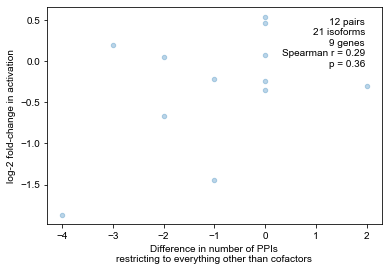

In [23]:
# restrict to no change with cofactors
# BUG: file name could overwrite?
scatter_with_correlation(
    pairs=pairs.loc[(pairs['ppi_n_tested_coactivators'] >= 1) & (pairs['ppi_n_shared_cofactors'] == pairs['ppi_n_tested_coactivators']), :],
    x='ppi_delta_n_not_cofactors',
    y='activation_fold_change',
    x_label='Difference in number of PPIs\nrestricting to everything other than cofactors',
    y_label='log-2 fold-change in activation')

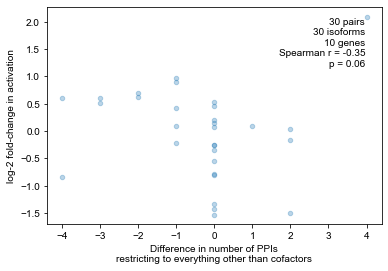

In [31]:
scatter_with_correlation(
    pairs=pairs.loc[(pairs['ppi_n_diff_coactivators'] == 0), :],
    x='ppi_delta_n',
    y='activation_fold_change',
    x_label='Difference in number of PPIs\nrestricting to everything other than cofactors',
    y_label='log-2 fold-change in activation')

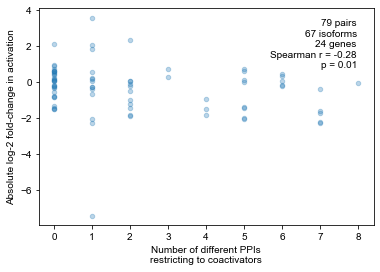

In [56]:
scatter_with_correlation(
    x='ppi_n_diff_coactivators',
    y='activation_fold_change',
    x_label='Number of different PPIs\nrestricting to coactivators',
    y_label='Absolute log-2 fold-change in activation')

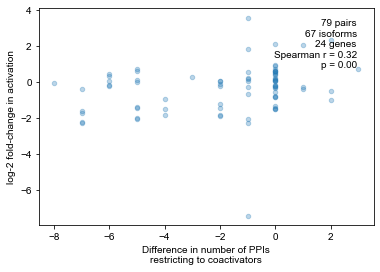

In [57]:
scatter_with_correlation(
    x='ppi_delta_n_coactivators',
    y='activation_fold_change',
    x_label='Difference in number of PPIs\nrestricting to coactivators',
    y_label='log-2 fold-change in activation')

In [ ]:
scatter_with_correlation(
    x='ppi_delta_n_TFs',
    y='activation_fold_change',
    x_label='Difference in number of PPIs\nrestricting to TFs',
    y_label='log-2 fold-change in activation')

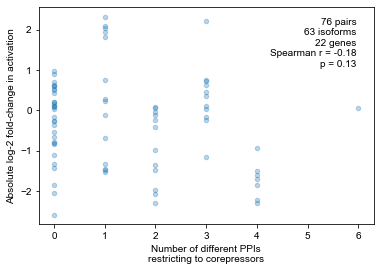

In [58]:
scatter_with_correlation(
    x='ppi_n_diff_corepressors',
    y='activation_fold_change',
    x_label='Number of different PPIs\nrestricting to corepressors',
    y_label='Absolute log-2 fold-change in activation')

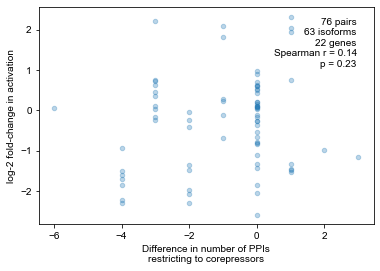

In [59]:
scatter_with_correlation(
    x='ppi_delta_n_corepressors',
    y='activation_fold_change',
    x_label='Difference in number of PPIs\nrestricting to corepressors',
    y_label='log-2 fold-change in activation')

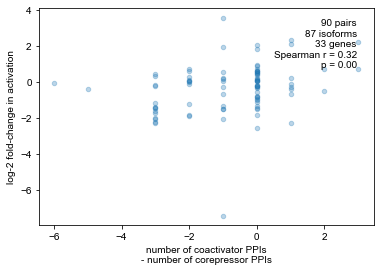

In [60]:
# co-repressors minus coactivators
pairs['ppi_delta_n_coactivators_minus_corepressors'] = pairs['ppi_delta_n_coactivators'].fillna(0) - pairs['ppi_delta_n_corepressors'].fillna(0)
pairs.loc[pairs['ppi_delta_n_coactivators'].isnull() & pairs['ppi_delta_n_corepressors'].isnull(),
          'ppi_delta_n_coactivators_minus_corepressors'] = np.nan
scatter_with_correlation(
    x='ppi_delta_n_coactivators_minus_corepressors',
    y='activation_fold_change',
    x_label='number of coactivator PPIs\n- number of corepressor PPIs',
    y_label='log-2 fold-change in activation')

In [72]:
# look at the biggest difference examples
(pairs.loc[pairs['ppi_n_diff'] > 0, 
['tf_gene_symbol', 'clone_acc_a', 'clone_acc_b', 'activation_abs_fold_change', 'ppi_n_tested', 'ppi_n_diff', 'ppi_n_diff_cofactors']]
.sort_values('activation_abs_fold_change', ascending=False).head(25)
)

,tf_gene_symbol,clone_acc_a,clone_acc_b,activation_abs_fold_change,ppi_n_tested,ppi_n_diff,ppi_n_diff_cofactors
pair,,,,,,,
E2F3|2/4|10A08_E2F3|3/4|10B08,E2F3,E2F3|2/4|10A08,E2F3|3/4|10B08,7.433645,5.0,3.0,1.0
ATF2|3/6|09C05_ATF2|5/6|09A05,ATF2,ATF2|3/6|09C05,ATF2|5/6|09A05,4.012971,3.0,3.0,NaN
ATF2|4/6|09B05_ATF2|5/6|09A05,ATF2,ATF2|4/6|09B05,ATF2|5/6|09A05,3.793690,3.0,3.0,NaN
ZSCAN18|1/7|09F02_ZSCAN18|2/7|09A01,ZSCAN18,ZSCAN18|1/7|09F02,ZSCAN18|2/7|09A01,3.572874,10.0,10.0,1.0
ATF2|1/6|12H04_ATF2|5/6|09A05,ATF2,ATF2|1/6|12H04,ATF2|5/6|09A05,3.306912,3.0,2.0,NaN
TCF12|1/3|07D07_TCF12|3/3|07B07,TCF12,TCF12|1/3|07D07,TCF12|3/3|07B07,2.587343,32.0,18.0,1.0
ATF2|2/6|09E05_ATF2|3/6|09C05,ATF2,ATF2|2/6|09E05,ATF2|3/6|09C05,2.514896,3.0,1.0,NaN
CREB5|1/3|08E11_CREB5|2/3|08A12,CREB5,CREB5|1/3|08E11,CREB5|2/3|08A12,2.342060,10.0,9.0,NaN
TCF4|6/9|07H03_TCF4|7/9|07G03,TCF4,TCF4|6/9|07H03,TCF4|7/9|07G03,2.319941,94.0,54.0,6.0


In [85]:
# look for repression differences



(pairs.loc[(pairs['ppi_n_diff'] > 0) & pairs['tf_gene_symbol'].isin(m1h.loc[(m1h['M1H_rep1'] < -1), 'gene'].unique()), 
['tf_gene_symbol', 'clone_acc_a', 'clone_acc_b', 'activation_abs_fold_change', 'ppi_n_tested', 'ppi_n_diff', 'ppi_n_diff_cofactors']]
.sort_values('activation_abs_fold_change', ascending=False).head(25)
)

,tf_gene_symbol,clone_acc_a,clone_acc_b,activation_abs_fold_change,ppi_n_tested,ppi_n_diff,ppi_n_diff_cofactors
pair,,,,,,,
ZBTB44|1/9|12B06_ZBTB44|3/9|10B06,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,1.525376,15.0,8.0,1.0
ZBTB44|1/9|12B06_ZBTB44|5/9|10H05,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,1.493713,17.0,10.0,1.0
ZBTB44|1/9|12B06_ZBTB44|6/9|12H02,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|6/9|12H02,1.445209,12.0,6.0,3.0
ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,1.324958,17.0,12.0,2.0
RFX4|1/3|10C04_RFX4|2/3|10D02,RFX4,RFX4|1/3|10C04,RFX4|2/3|10D02,0.660592,8.0,3.0,1.0
ZBTB44|3/9|10B06_ZBTB44|4/9|10H06,ZBTB44,ZBTB44|3/9|10B06,ZBTB44|4/9|10H06,0.200418,13.0,4.0,1.0
ZBTB44|4/9|10H06_ZBTB44|5/9|10H05,ZBTB44,ZBTB44|4/9|10H06,ZBTB44|5/9|10H05,0.168756,13.0,2.0,1.0
ZBTB44|4/9|10H06_ZBTB44|6/9|12H02,ZBTB44,ZBTB44|4/9|10H06,ZBTB44|6/9|12H02,0.120251,15.0,12.0,5.0
ZBTB44|3/9|10B06_ZBTB44|6/9|12H02,ZBTB44,ZBTB44|3/9|10B06,ZBTB44|6/9|12H02,0.080167,13.0,8.0,4.0


MannwhitneyuResult(statistic=1779.0, pvalue=0.20397515799215887)

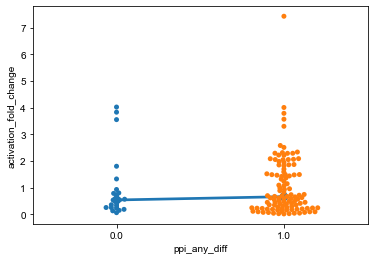

In [78]:
# do category plot on some vs no difference
pairs['ppi_any_diff'] = pairs['ppi_n_diff'] != 0
pairs.loc[pairs['ppi_n_diff'].isnull(), 'ppi_any_diff'] = np.nan
x = 'ppi_any_diff'
y = 'activation_fold_change'
sns.swarmplot(data=pairs, x='ppi_any_diff', y='activation_fold_change')
sns.pointplot(data=pairs, x='ppi_any_diff', y='activation_fold_change', estimator=np.median)
stats.mannwhitneyu(pairs.loc[pairs[x] == True, y], pairs.loc[pairs[x] == False, y])

In [62]:
pairs['ppi_n_diff'].value_counts().sum()

158

In [60]:
pairs['ppi_any_diff'].value_counts()

True     773
False     31
Name: ppi_any_diff, dtype: int64

MannwhitneyuResult(statistic=1459.0, pvalue=0.16648564453642156)

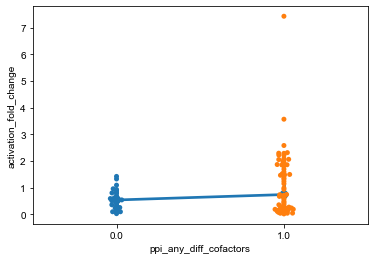

In [65]:
pairs['ppi_any_diff_cofactors'] = pairs['ppi_n_diff_cofactors'] != 0
pairs.loc[pairs['ppi_n_diff_cofactors'].isnull(), 'ppi_any_diff_cofactors'] = np.nan
x = 'ppi_any_diff_cofactors'
y = 'activation_fold_change'
sns.swarmplot(data=pairs, x='ppi_any_diff_cofactors', y='activation_fold_change')
sns.pointplot(data=pairs, x='ppi_any_diff_cofactors', y='activation_fold_change', estimator=np.median)
stats.mannwhitneyu(pairs.loc[pairs[x] == True, y], pairs.loc[pairs[x] == False, y])

MannwhitneyuResult(statistic=1778.0, pvalue=0.22080733182898316)

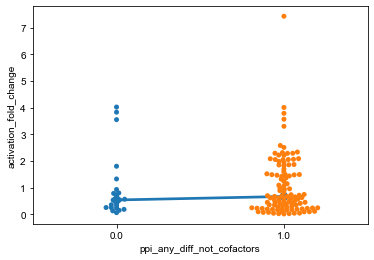

In [79]:
x = 'ppi_any_diff_not_cofactors'
y = 'activation_fold_change'
pairs['ppi_any_diff_not_cofactors'] = pairs['ppi_n_diff_not_cofactors'] != 0
pairs.loc[pairs['ppi_n_diff_not_cofactors'].isnull(), 'ppi_any_diff_not_cofactors'] = np.nan
sns.swarmplot(data=pairs, x='ppi_any_diff_not_cofactors', y='activation_fold_change')
sns.pointplot(data=pairs, x='ppi_any_diff_not_cofactors', y='activation_fold_change', estimator=np.median)
stats.mannwhitneyu(pairs.loc[pairs[x] == True, y], pairs.loc[pairs[x] == False, y])

In [94]:
# what is the best metric for PPI partners whose loss is most associciated with change in
# activation?

def ppi_tf_gene(data, gene_name):
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    return tf

# for each tf, for each partner, if differentially bound, absolute change in activation
data = []
for tf_gene in y2h['ad_gene_symbol'].unique():
    tf_ppi = ppi_tf_gene(y2h, tf_gene)
    tf_ppi = tf_ppi.loc[tf_ppi.any(axis=1), :]
    if tf_ppi.shape[0] < 2:
        continue
    tf_ppi = tf_ppi.loc[:, (tf_ppi == True).any(axis=0) & (tf_ppi == False).any(axis=0)]
    for partner in tf_ppi.columns:
        binds = tf_ppi.index[tf_ppi[partner] == True].values
        not_binds = tf_ppi.index[tf_ppi[partner] == False].values
        actv_diff = (m1h.loc[m1h['clone_acc'].isin(binds), ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean().mean()
                     - m1h.loc[m1h['clone_acc'].isin(not_binds), ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean().mean())
        data.append([tf_gene, partner, actv_diff])
df = pd.DataFrame(data=data, columns=['tf_gene', 'partner', 'activation_diff']).dropna()
df['num_points'] = df['partner'].map(df['partner'].value_counts())
df = df.sort_values(['num_points', 'partner', 'activation_diff'], ascending=False)

In [132]:
df.head(12)

,tf_gene,partner,activation_diff,num_points
335,MEIS2,ZNF417,1.332599,6
133,TCF4,ZNF417,0.803438,6
178,HMBOX1,ZNF417,0.228410,6
494,ZBTB44,ZNF417,-1.628360,6
298,ESRRG,ZNF417,-1.955542,6
446,ZSCAN18,ZNF417,-3.572874,6
455,E2F3,PRKAA2,7.433645,6
291,FOSB,PRKAA2,2.293175,6
96,TCF4,PRKAA2,1.774368,6
296,NFYA,PRKAA2,0.834103,6


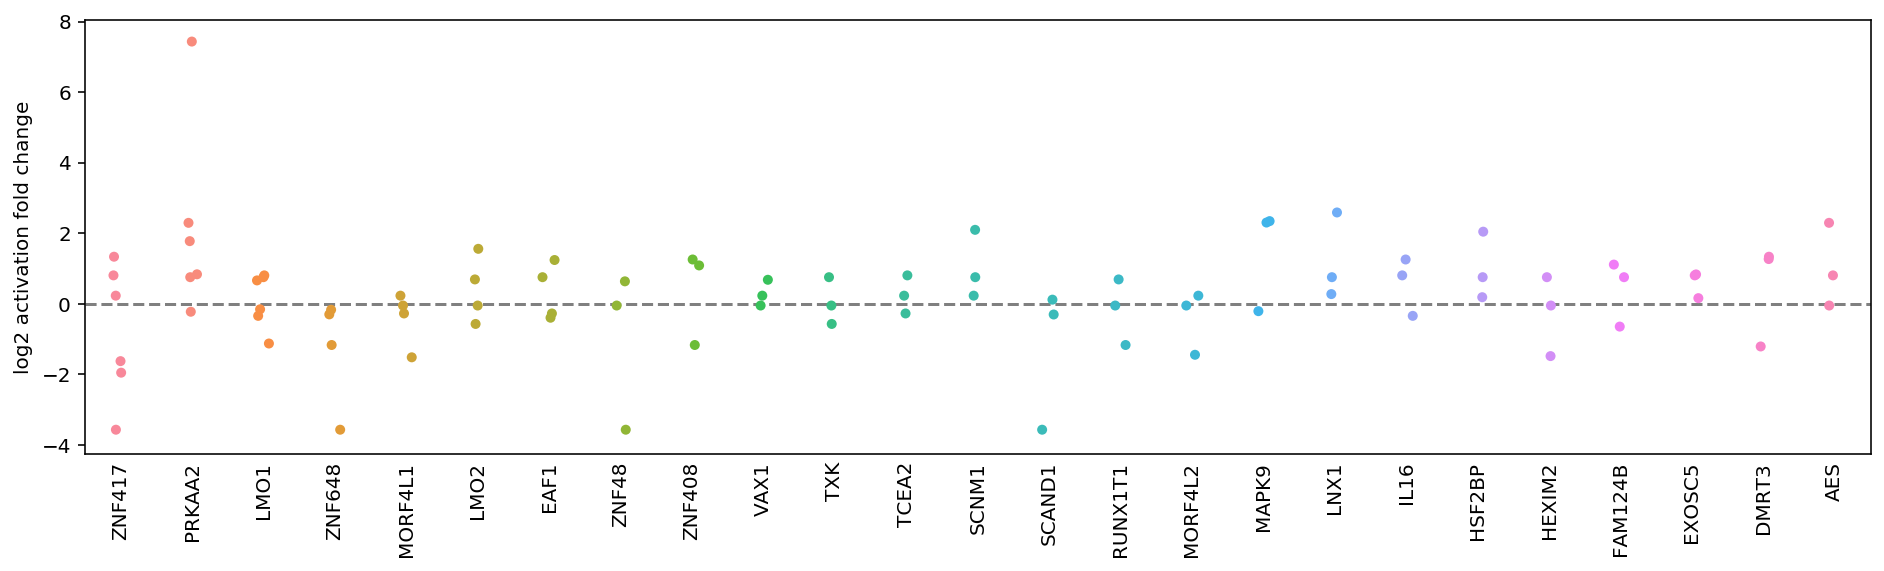

In [137]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.stripplot(data=df.loc[df['num_points'] > 2, :],
              x='partner',
              y='activation_diff',
              ax=ax)
ax.axhline(0, linestyle='--', color='grey')
ax.set_xlabel('')
ax.set_ylabel('log2 activation fold change')
ax.tick_params(axis='x', rotation=90, length=0)
plt.savefig('../figures/activation_change_per_ppi_partner.pdf',
            bbox_inches='tight')